In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import solve
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy import optimize
from scipy.optimize import minimize_scalar
import egrss 
import lambda_fun
import os 
import scipy.stats
import matplotlib.patches as mpatches

data = pd.read_csv("archive.csv") 

blue1 = 'cornflowerblue'
blue2 = 'navy'
red = 'tomato'

dates = data['Decimal Date'].to_numpy()
carbon = data['Carbon Dioxide (ppm)'].to_numpy()
dates = dates[np.logical_not(np.isnan(carbon))]
carbon = carbon[np.logical_not(np.isnan(carbon))]

n = len(carbon)



a,b = np.min(dates), np.max(dates)
p = 2
xi = (b-a) ** (2 * p - 1) 


def smoothing_spline_reg(y,Ut,Vt,Wt,eps,nu,tau,perturb = None):
    # compute factorization
    d    =   tau / nu
    Zt,c = egrss.potrf(Ut,Vt,d)
    
    # compute rhs
    if perturb is not None: 
        # perturbation of rhs
        n,  = y.shape
        xiy = np.random.normal(loc=0, scale=1, size= n)
        xix = np.random.normal(loc=0, scale=1, size= n)       
        rhs = egrss.symv(Utilde,Vtilde,y+ np.sqrt(nu) / nu * xiy) + np.sqrt(tau) / nu * egrss.trmv(Utilde, Wtilde, xix, c = eps, trans = 'N')
        
    else:
        rhs = egrss.symv(Utilde,Vtilde,y)
        
    # solve LL'x = rhs    
    Ltrhs= egrss.trsv(Ut,Zt,rhs,c,'N')
    x    = egrss.trsv(Ut,Zt,Ltrhs,c,'T')
        
    return x

def plims(x,p = None):
    # computes the emperical quantiles of x
    # m is number of samples
    # n is number of parameters
    
    m,n = x.shape
    
    if p is None: 
        p = np.array([0.025, 0.975]) # corresponds to 95% CI
        
    k, = p.shape
    y = np.zeros((k,n))
    for i in range(n):
        y[:,i] = np.interp((m-1)*p,range(m),np.sort(x[:,i])) 
    
    return y

### Gibbs sampler - we aim to sample from the joint posterior pi(v,u,sigma,nuda,tau|y) 
# See posteriors derived in overleaf
import time
nsamps = 5000
K      = 2 # equvalent to degree of spline

alph   = 1e+3



# pre-compute matrices and matrix-vector products
Ut, Vt = egrss.generators((dates-a)/(b-a),K)

Utilde = Ut
Vtilde = Vt + alph * Ut
Wtilde,eps = egrss.potrf(Utilde,Vtilde,1e-10)

residual = carbon

nsamps = 10000
s      = 2
J = 10
b_range = np.logspace(-6,3,10)

burnin   = int(nsamps/2) 

z_res = np.zeros([J, n , burnin])
bet_res   = np.zeros([J, s, burnin])
y_res   = np.zeros([J,n, burnin])
del_res = np.zeros([J, burnin])
tau_res   = np.zeros([J, burnin])
gam_res   = np.zeros([J, burnin])

z_mean = np.zeros([J,n])
bet_mean = np.zeros([J,s])
y_mean   = np.zeros([J, n])
del_mean = np.zeros(J)
tau_mean = np.zeros(J)
gam_mean = np.zeros(J)

nu_ci  = np.zeros([J, 2, n])
tau_ci  = np.zeros([J, 2, n])
x_ci     = np.zeros([J, 2, n])

del_ci  = np.zeros(J)
tau_ci  = np.zeros(J)
gam_ci  = np.zeros(J)
y_ci    = np.zeros([J,2,n])

for j in range(J):
    # Initialization and memory allocation
    del_samp   = np.zeros(nsamps)
    tau_samp   = np.zeros(nsamps)
    gam_samp   = np.zeros(nsamps)
    z_samp     = np.zeros((n,nsamps))
    bet_samp   = np.zeros((s,nsamps))
    y_samp     = np.zeros((n,nsamps))

    # pre-compute matrices and matrix-vector products
    Ft, Vt = egrss.generators((dates-a)/(b-a),s)       
    Wt,eps   = egrss.potrf(Ft,Vt,1e-10) # regularizes the factorization

    # initializations
    Fb       = Ft.T @ bet_samp[:,0]
    residual = np.zeros((n,))

    for i in range(nsamps-1):      
        # sample hyperparameters lambda and nu (delta and alpha)
        # (1a) sample delta    
        a0,b0         = 1.0 + n / 2, b_range[j] + 0.5 * (residual.T @ residual)
        del_samp[i+1] =  1 / np.random.gamma(shape=a0, scale=1/b0)

        # (1b) sample tau
        tmp           = egrss.trsv(Ft,Wt,z_samp[:,i],eps,'N')
        a1,b1         = 1.0 + n / 2, 1e-2 + 0.5 * (tmp.T @ tmp)
        tau_samp[i+1] = 1/ np.random.gamma(shape=a1, scale=1/b1)

        # (1c) sample gamma
        a2,b2    = 1.0 + s / 2, 1e+4+ 0.5 * (bet_samp[:,i].T @ bet_samp[:,i])
        gam_samp[i+1] =  np.random.gamma(shape=a2, scale=1/b2)

        # 2) Compute posterior for z and beta 
        # 2a) Compute posterior for z
        xiy   = np.random.normal(loc=0, scale=1, size= n)
        xia   = np.random.normal(loc=0, scale=1, size= n)
        d     = del_samp[i+1] / tau_samp[i+1]
        Zt,c  = egrss.potrf(Ft,Vt,d)
        rhs   = egrss.symv(Ft,Vt,carbon - Fb + del_samp[i+1]  / np.sqrt(del_samp[i+1]) *  xiy) + del_samp[i+1]  / np.sqrt(tau_samp[i+1]) * egrss.trmv(Ft, Wt, xia,eps,'N')
        Lrhs  = egrss.trsv(Ft,Zt,rhs,c,'N')
        z_samp[:,i+1] = egrss.trsv(Ft,Zt,Lrhs,c,'T')


        # 2b) Compute posterior for beta
        xib = np.random.normal(loc=0, scale=1, size= s)
        rhs = Ft @(carbon-z_samp[:,i+1]+ del_samp[i+1]  / np.sqrt(del_samp[i+1]) * xiy) + del_samp[i+1]  * np.sqrt(gam_samp[i+1]) * xib
        d   = del_samp[i+1] * gam_samp[i+1]
        M   = Ft @Ft.T + d * np.eye(s)
        bet_samp[:,i+1] = np.linalg.solve(M,rhs)

        # update y
        Fb            = Ft.T @ bet_samp[:,i+1]
        y_samp[:,i+1] = z_samp[:,i+1] + Fb

        # update residual
        residual      = carbon- y_samp[:,i+1]

    ## Sample statistics 
    # Remove burn-in phase 
    nmax     = nsamps #burnin+2000
    z_res[j,:,:]    = z_samp[:,burnin:nmax]
    bet_res[j,:,:]  = bet_samp[:,burnin:nmax]
    y_res[j,:,:]    = y_samp[:,burnin:nmax]

    del_res[j,:] = del_samp[burnin:nmax]
    tau_res[j,:] = tau_samp[burnin:nmax]
    gam_res[j,:] = gam_samp[burnin:nmax]
    
    del_reshape = del_res[j,:]
    tau_reshape = tau_res[j,:]
    gam_reshape = gam_res[j,:]
    
    # Reshape results for statistical functions 
    del_reshape.shape=(nmax-burnin,1)
    tau_reshape.shape=(nmax-burnin,1)
    gam_reshape.shape=(nmax-burnin,1)

    # Compute posterior mean 
    del_mean[j] = np.mean(del_reshape,0)
    tau_mean[j] = np.mean(tau_reshape,0)
    gam_mean[j] = np.mean(gam_reshape,0)
    z_mean[j,:]   = np.mean(z_res[j,:,:],1)
    bet_mean[j,:] = np.mean(bet_res[j,:,:],1)
    y_mean[j,:]   = np.mean(y_res[j,:,:],1)

    # Compute 95% CI 
    #del_ci[j]  = plims(del_reshape)
    #tau_ci[j]  = plims(tau_reshape)
    #gam_ci[j]  = plims(gam_reshape)
    y_ci[j,:,:]    = plims(y_res[j,:,:].T)

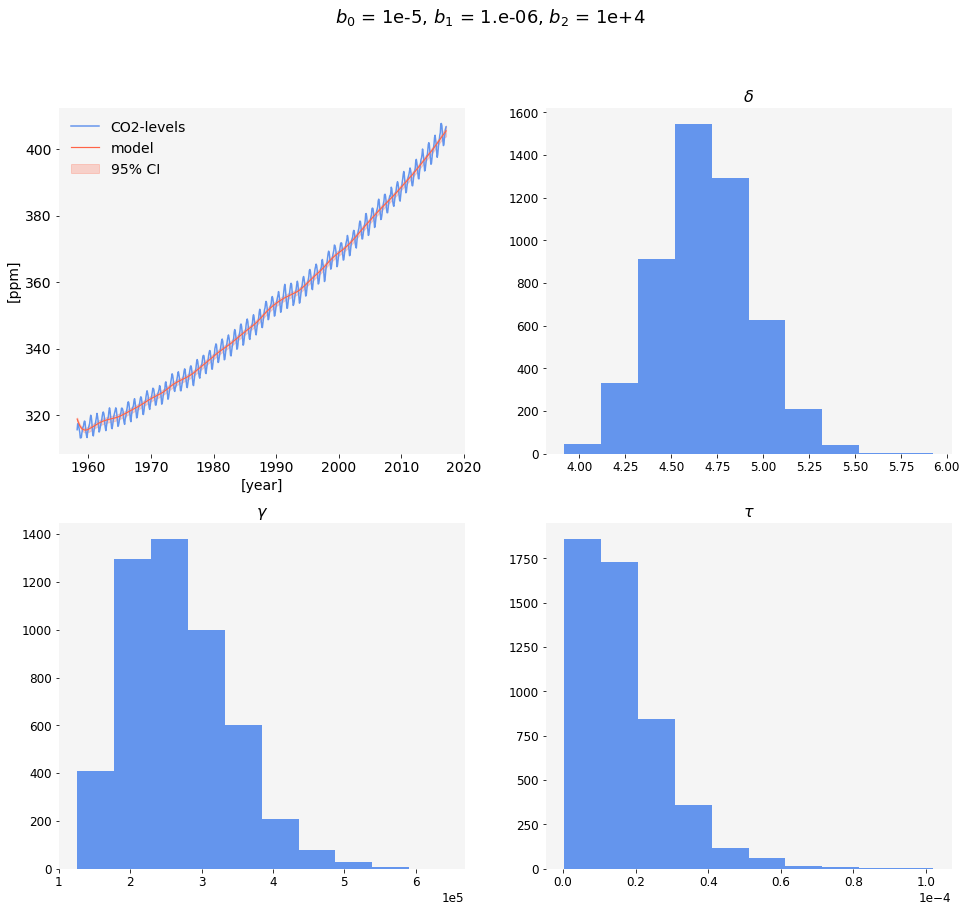

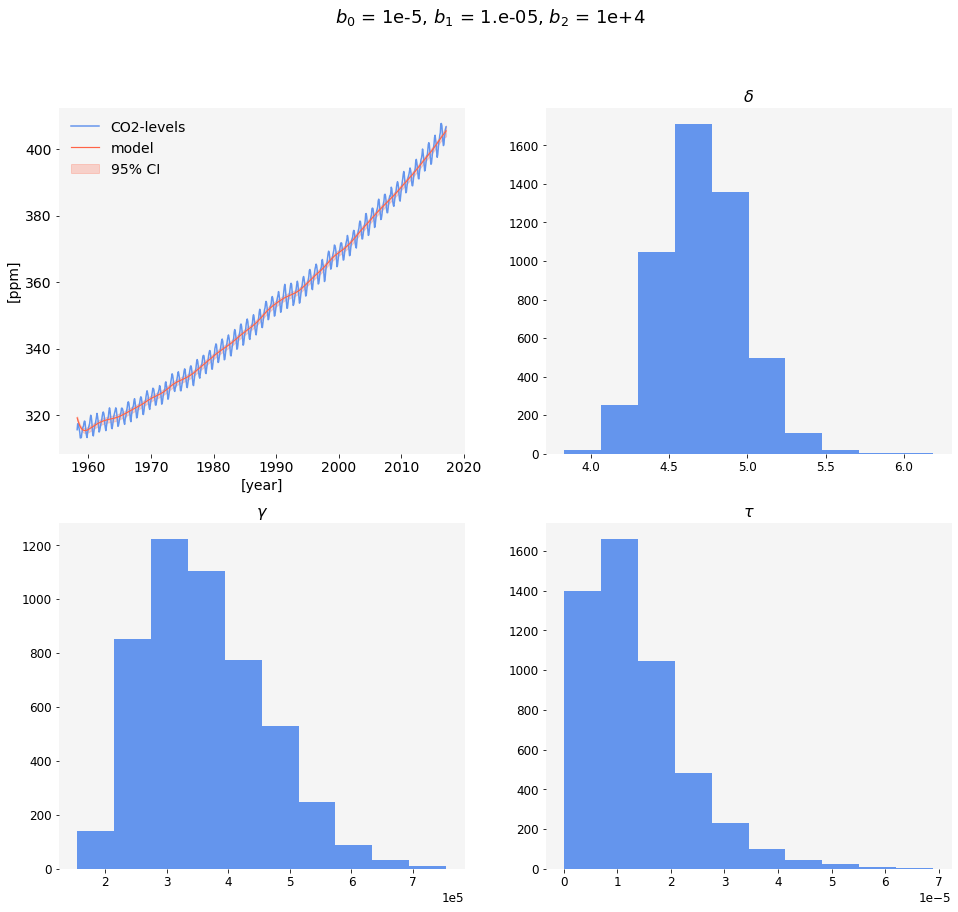

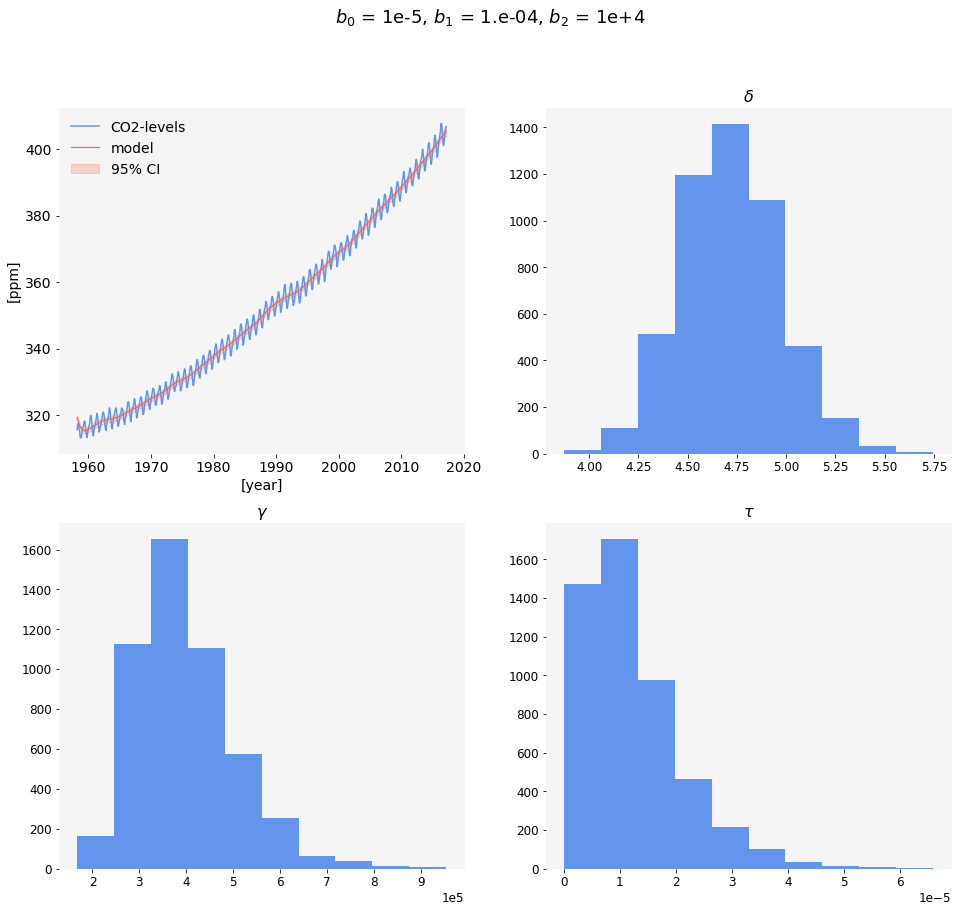

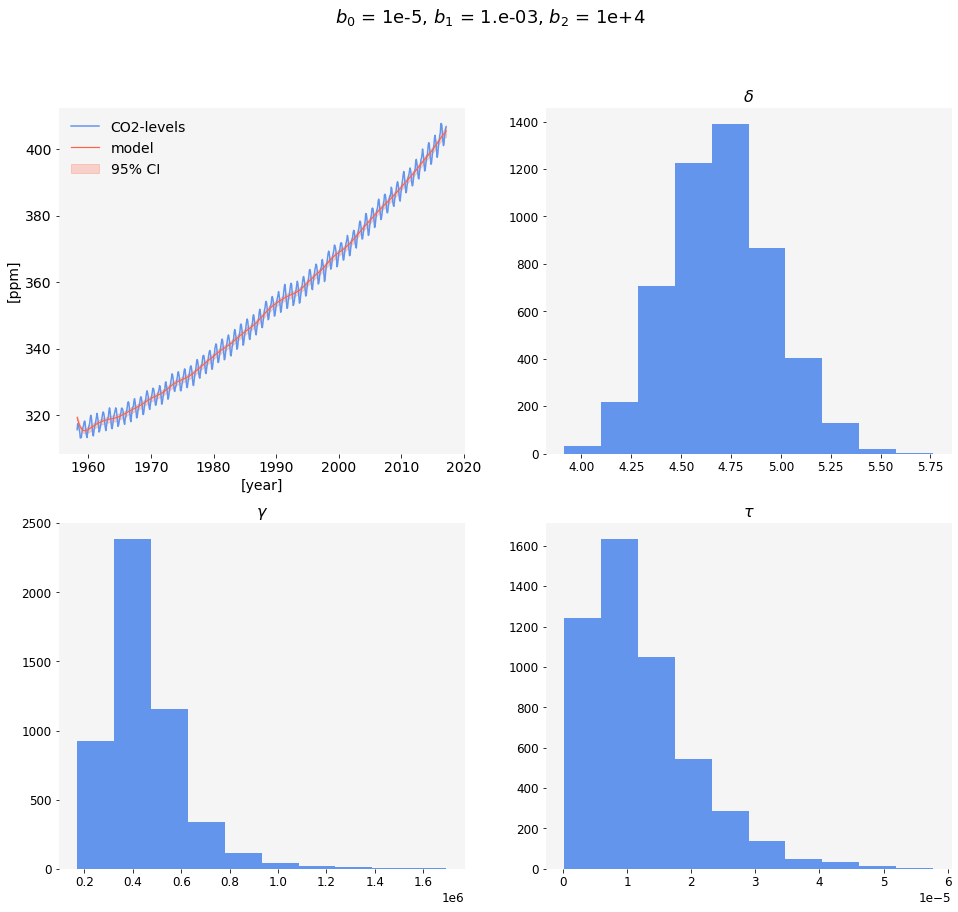

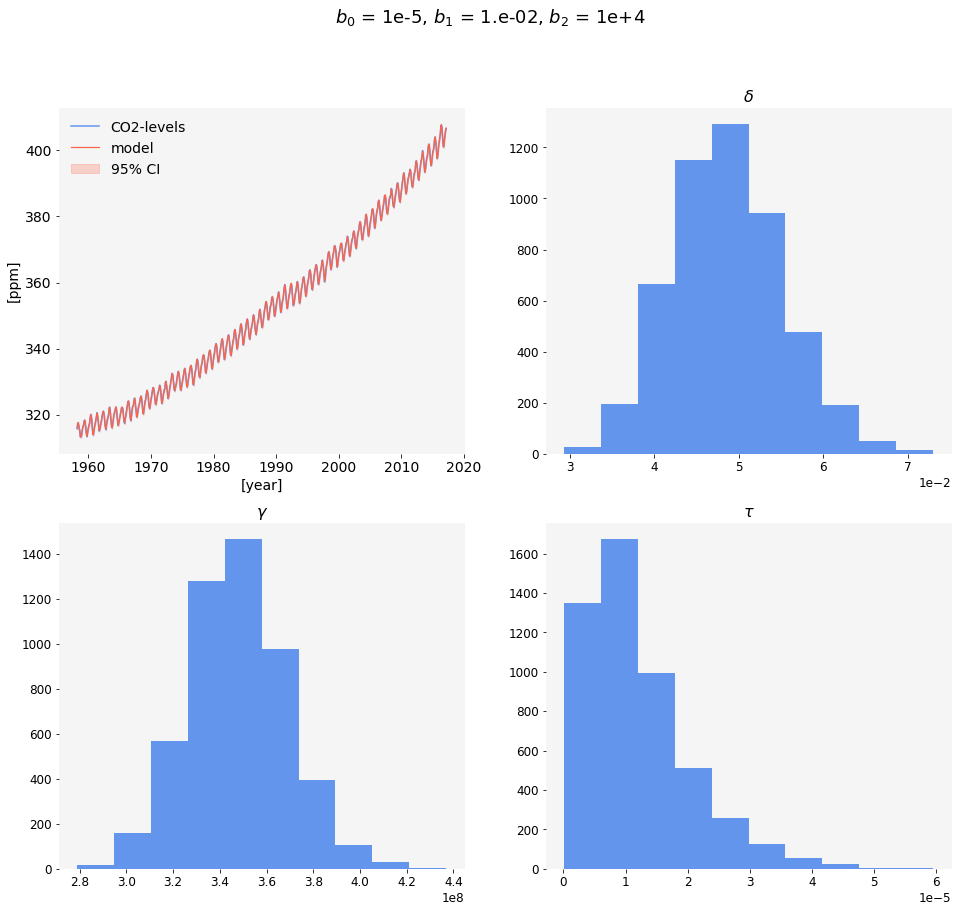

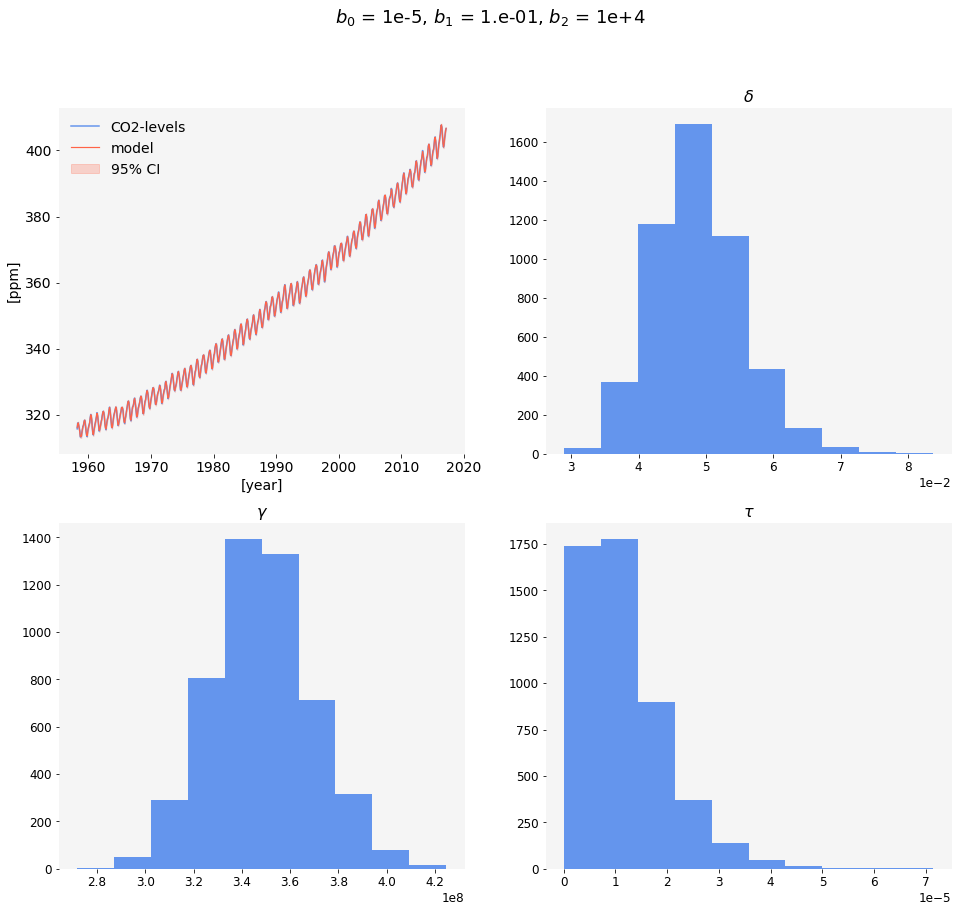

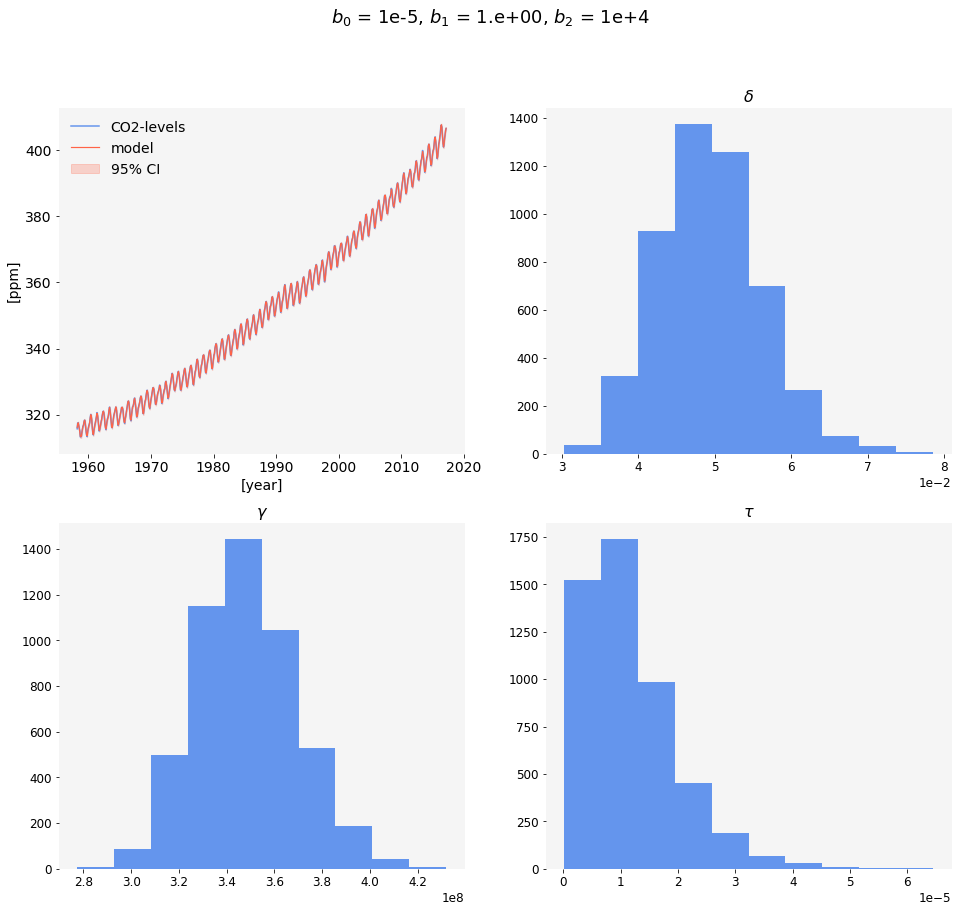

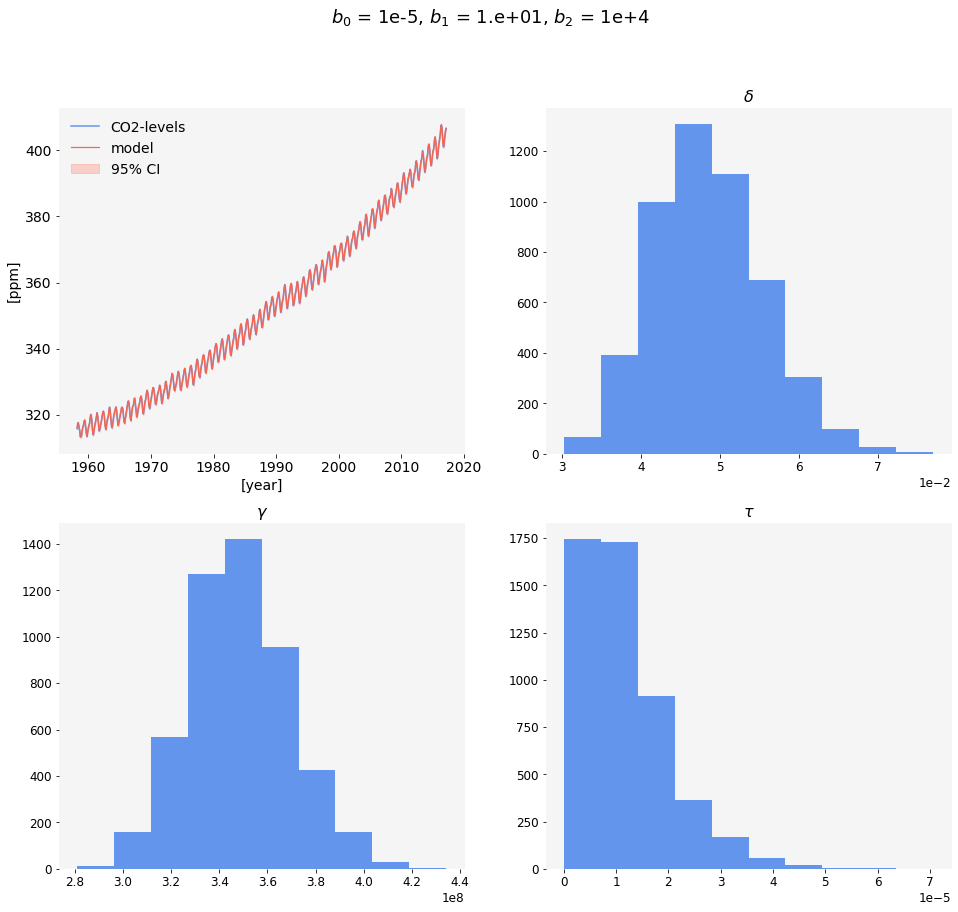

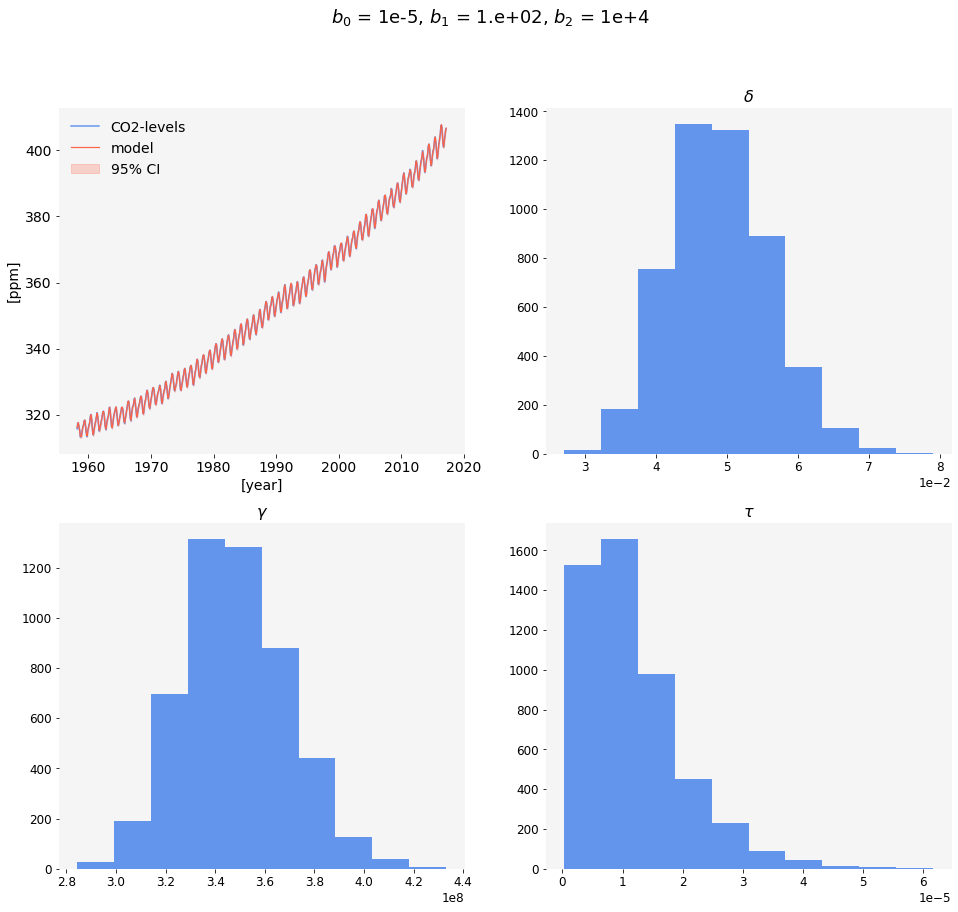

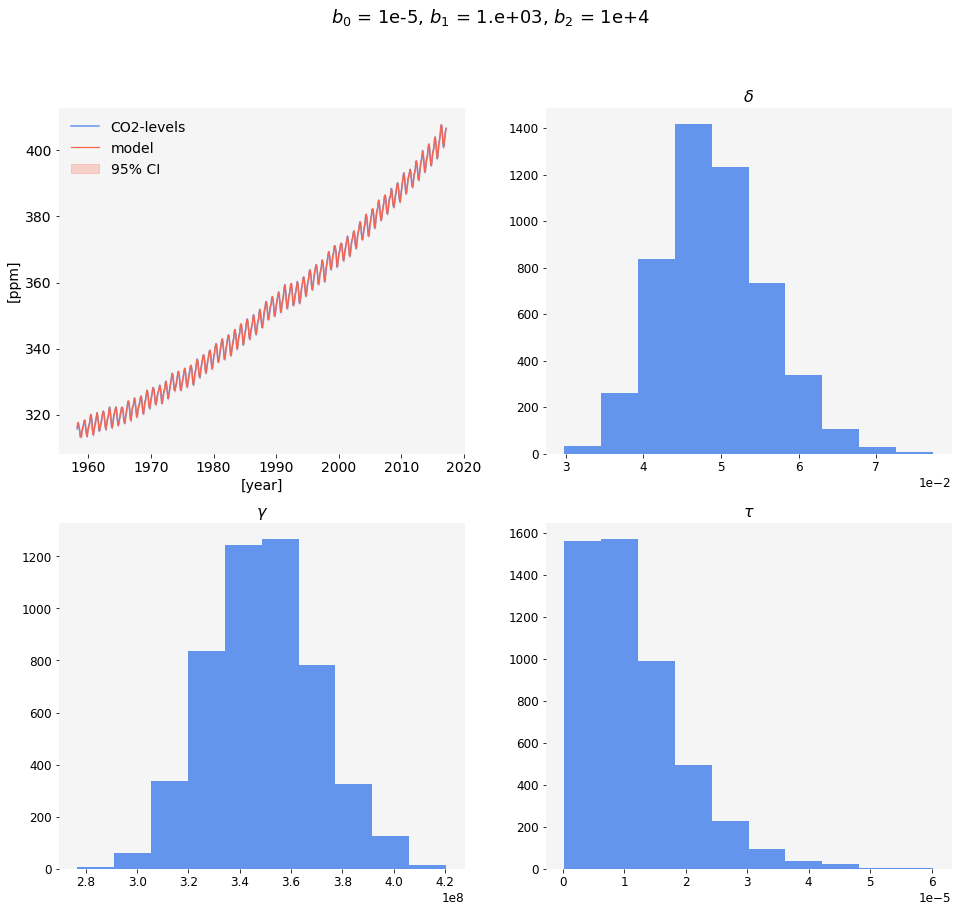

In [25]:
fs = 16
ts = 12
col1 = 'cornflowerblue'
for j in range(J):
    fig = plt.figure()
    plt.subplot(2,2,1)
    plt.plot(dates,carbon,color = 'cornflowerblue', label = '$\hat{y}_i$')
    plt.plot(dates,y_mean[j,:] ,color = 'tomato', linewidth=1.2, label = 'model')
    plt.fill_between(dates,y_ci[j,0,:],y_ci[j,1,:], color='tomato', alpha=.25,label = '$95\%$ CI')
    plt.ylabel('[ppm]', fontsize = 14)
    plt.xlabel('[year]', fontsize = 14)
    plt.legend(['CO2-levels', 'model', '95% CI'], numpoints = 1, prop = {'size': 14}, loc = 'upper left', frameon = False)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    plt.subplot(2,2,2)
    plt.hist(del_res[j,:], color = col1)
    plt.ticklabel_format(axis = 'x', style = 'sci', scilimits=(0,0))
    plt.title('$\\delta$', fontsize = fs)
    plt.xticks(fontsize = ts)
    plt.yticks(fontsize = ts)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    ax.xaxis.get_offset_text().set_fontsize(ts)

    plt.subplot(2,2,3)
    plt.hist(tau_res[j,:], color = col1)
    plt.title('$\\gamma$', fontsize = fs)
    plt.ticklabel_format(axis = 'x', style = 'sci', scilimits=(0,0))
    plt.xticks(fontsize = ts)
    plt.yticks(fontsize = ts)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    ax.xaxis.get_offset_text().set_fontsize(ts)
        
    plt.subplot(2,2,4)
    plt.hist(gam_res[j,:], color = col1)
    plt.title('$\\tau$', fontsize = fs)
    plt.ticklabel_format(axis = 'x', style = 'sci', scilimits=(0,0))
    plt.xticks(fontsize = ts)
    plt.yticks(fontsize = ts)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    ax.xaxis.get_offset_text().set_fontsize(ts)

    fig.set_figheight(10)
    fig.set_figwidth(20)
        
    fig.suptitle('$b_0$ = %s, $b_1$ = 1e-2, $b_2$ = 1e+4' %(np.format_float_scientific(b_range[j], precision = 3, exp_digits=2)), fontsize=18)
    
    fig.set_figheight(14)
    fig.set_figwidth(16)
    plt.show()
    
    

    my_path = os.getcwd()
    fig.savefig(my_path + '/Plots/sampling_resHb0' + str(j+1) + '.pdf', bbox_inches='tight')

In [6]:
0.0001 == 1e-4

True